In [1]:
import os
import random
from tqdm import tqdm

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

from src.model import Model
from src import utils
from src.pytorch_utils import utils as ptu
from config import cfg
import src.data_loader as dl

%load_ext autoreload
%autoreload 2

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
cfg.model_type = 'base' #write it in config file
model_epoch = 'best'
if cfg.load is not None and os.path.exists(os.path.join(cfg.models_dir, cfg.version, ptu.naming_scheme(cfg.version, epoch=model_epoch)) + '.pth'):
    print(f'Loads {cfg.version}')
    checkpoint = ptu.load_model(device, version=cfg.version, models_dir=cfg.models_dir, epoch=model_epoch)
    if cfg.prints == 'display':
        display(checkpoint.log.sort_index(ascending=False).head(20))
    elif cfg.prints == 'print':
        print(checkpoint.log.sort_index(ascending=False).head(20))
else:
    model = Model(backbone=cfg.backbone, num_classes=cfg.num_classes,
                  feature_extraction_dataset=cfg.feature_extraction_dataset)
    model.to(device)
    
    if cfg.optimizer == 'sgd':
        optimizer = torch.optim.SGD(model.model.fc.parameters(),
                                    lr=cfg.lr,
                                    momentum=cfg.optimizer_momentum,
                                    weight_decay=cfg.wd)
    else:
        optimizer = torch.optim.Adam(model.model.fc.parameters(),
                                    lr=cfg.lr,
                                    weight_decay=cfg.wd)
    
    criterion = nn.CrossEntropyLoss().to(device)
    
    lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,
                                                              T_max=cfg.epochs,
                                                              eta_min=cfg.min_lr)
    
    checkpoint = utils.Checkpoint(version=cfg.version,
                                  model=model,
                                  optimizer=optimizer,
                                  lr_scheduler=lr_scheduler,
                                  criterion=criterion,
                                  score=utils.accuracy_score,
                                  models_dir=cfg.models_dir,
                                  best_policy=cfg.best_policy,
                                  save=cfg.save,
                                 )

feature_extraction_process


In [4]:
train_loader, train_eval_loader = dl.train_eval_loaders_cifar10(data_dir=cfg.data_dir, batch_size=cfg.bs,
                                                                feature_extraction=cfg.feature_extraction_dataset)
test_loader = dl.test_loader(data_dir=cfg.data_dir, batch_size=cfg.bs,
                             feature_extraction=cfg.feature_extraction_dataset)

In [5]:
checkpoint.train(train_loader=train_loader,
                 train_eval_loader=train_eval_loader,
                 val_loader=test_loader,
                 train_epochs=int(max(0, cfg.epochs - checkpoint.get_log())),
                 optimizer_params=cfg.optimizer_params,
                 prints=cfg.prints,
                 epochs_save=cfg.epochs_save,
                 epochs_evaluate_train=cfg.epochs_evaluate_train,
                 epochs_evaluate_validation=cfg.epochs_evaluate_validation,
                 max_iterations_train=cfg.max_iterations,
                 max_iterations_val=cfg.max_iterations,
                 device=device,
                 tqdm_bar=cfg.tqdm_bar,
                 save=cfg.save,
                 save_log=cfg.save_log,
                )

epoch=1: 100%|██████████| 64/64 [00:00<00:00, 100.12it/s, loss=3.38, avg_loss=2.61, score=0.219]


KeyboardInterrupt: 

/home/na.tali/236605/src/pytorch_utils/checkpoint.py:308: UserWarning: Attempting to set identical left == right == 1.0 results in singular transformations; automatically expanding.
  plt.xlim(min_e - (max_e - min_e)*0.02, max_e + (max_e - min_e)*0.02)


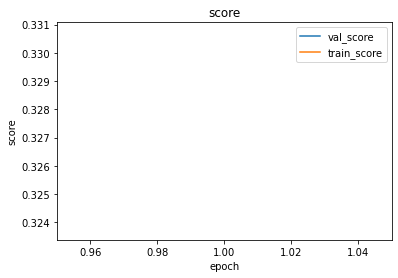

/home/na.tali/236605/src/pytorch_utils/checkpoint.py:308: UserWarning: Attempting to set identical left == right == 1.0 results in singular transformations; automatically expanding.
  plt.xlim(min_e - (max_e - min_e)*0.02, max_e + (max_e - min_e)*0.02)


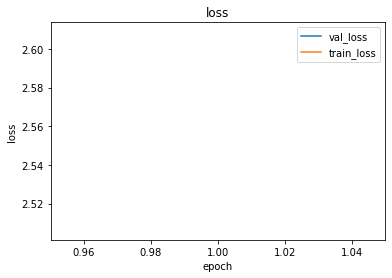

/home/na.tali/236605/src/pytorch_utils/checkpoint.py:308: UserWarning: Attempting to set identical left == right == 1.0 results in singular transformations; automatically expanding.
  plt.xlim(min_e - (max_e - min_e)*0.02, max_e + (max_e - min_e)*0.02)


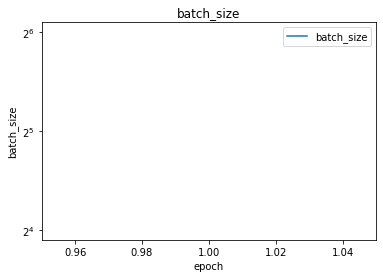

/home/na.tali/236605/src/pytorch_utils/checkpoint.py:308: UserWarning: Attempting to set identical left == right == 1.0 results in singular transformations; automatically expanding.
  plt.xlim(min_e - (max_e - min_e)*0.02, max_e + (max_e - min_e)*0.02)


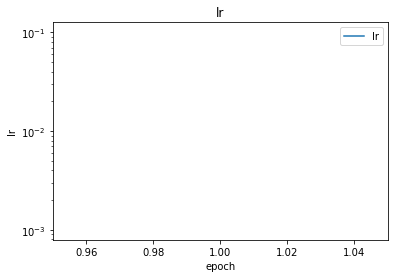

,train_time,timestamp,train_loss,val_loss,train_score,val_score,batch_size,best,dampening,initial_lr,lr,momentum,nesterov,weight_decay
1,0.035129,20:55:57 28-08-2021,2.506368,2.608638,0.330729,0.32373,32,True,0.0,0.01,0.01,0.9,0.0,0.0


In [6]:
checkpoint.summarize()

In [ ]:
df = pd.DataFrame(columns=['model', 'augment', 'class', 'angle', 'loss', 'score'])

In [ ]:
# # all classes
# for angle in range(0, 91, 10):
#     print(f'Angle {angle}')
#     test_loader = dl.test_loader(data_dir=cfg.data_dir,
#                                  batch_size=cfg.bs,
#                                  augment=True,
#                                  angles=[angle])
#     loss, score, results = checkpoint.evaluate(loader=test_loader,
#                                                device=device,
#                                                tqdm_bar=True)
#     df = df.append({'model': 'base', 'augment': 'rotation', 'class': 'all', 'angle': angle, 'loss': loss, 'score': score},
#                    ignore_index=True)

In [ ]:
# df

In [ ]:
# # by class by angle classes
# for class_name in utils.classDict.keys():
#     for angle in range(0, 91, 10):
#         print(f'Class {class_name}, Angle {angle}')
#         test_loader = dl.test_loader(data_dir=cfg.data_dir,
#                                      batch_size=cfg.bs,
#                                      augment=True,
#                                      angles=[angle],
#                                      class_name=class_name
#                                     )
#         loss, score, results = checkpoint.evaluate(loader=test_loader,
#                                                    device=device,
#                                                    tqdm_bar=True)
#         df = df.append({'model': 'base', 'augment': 'rotation', 'class': class_name, 'angle': angle, 'loss': loss, 'score': score},
#                        ignore_index=True)

In [ ]:
# df

In [ ]:
# df.to_csv('log.csv', index=False)

In [ ]:
# fig, axes = plt.subplots(figsize=(20,10),
#                          nrows=2, ncols=6)
# for (val, group), ax in zip(df.groupby('class'), axes.flatten()):
#     group.plot(x='angle', y='loss', kind='bar', ax=ax, title=val, ylim=(0, 7))

In [ ]:
# # df.groupby('class').plot.bar(x='angle', y='score', ylim=(0, 1), subplots=True)
# fig, axes = plt.subplots(figsize=(20,10),
#                          nrows=2, ncols=6)
# for (val, group), ax in zip(df.groupby('class'), axes.flatten()):
#     group.plot(x='angle', y='score', kind='bar', ax=ax, title=val, ylim=(0, 1))

## RandomRotation Model
##### Differ from base model in training with rotations at random angles from list [0, 10, ..., 90]

In [ ]:
cfg.model_type = 'randomRotation'
model_epoch = 'best'
if cfg.load is not None and os.path.exists(os.path.join(cfg.models_dir, cfg.version, ptu.naming_scheme(cfg.version, epoch=model_epoch)) + '.pth'):
    print(f'Loads {cfg.version}')
    checkpoint = ptu.load_model(device, version=cfg.version, models_dir=cfg.models_dir, epoch=model_epoch)
    if cfg.prints == 'display':
        display(checkpoint.log.sort_index(ascending=False).head(20))
    elif cfg.prints == 'print':
        print(checkpoint.log.sort_index(ascending=False).head(20))
else:
    model = Model(backbone=cfg.backbone, num_classes=cfg.num_classes)
    model.to(device)
    
    if cfg.optimizer == 'sgd':
        optimizer = torch.optim.SGD(model.model.fc.parameters(),
                                    lr=cfg.lr,
                                    momentum=cfg.optimizer_momentum,
                                    weight_decay=cfg.wd)
    else:
        optimizer = torch.optim.Adam(model.model.fc.parameters(),
                                    lr=cfg.lr,
                                    weight_decay=cfg.wd)
    
    criterion = nn.CrossEntropyLoss().to(device)
    
    lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,
                                                              T_max=cfg.epochs,
                                                              eta_min=cfg.min_lr)
    
    checkpoint = utils.Checkpoint(version=cfg.version,
                                  model=model,
                                  optimizer=optimizer,
                                  lr_scheduler=lr_scheduler,
                                  criterion=criterion,
                                  score=utils.accuracy_score,
                                  models_dir=cfg.models_dir,
                                  best_policy=cfg.best_policy,
                                  save=cfg.save,
                                 )

In [ ]:
train_loader, train_eval_loader = dl.train_eval_loaders_cifar10(data_dir=cfg.data_dir, batch_size=cfg.bs,
                                                                random_rotation=True, angles=list(range(0, 91, 10)))
test_loader = dl.test_loader(data_dir=cfg.data_dir, batch_size=cfg.bs)

In [ ]:
checkpoint.optimizer = torch.optim.SGD(checkpoint.model.model.fc.parameters(),
                                       lr=1e-3,  #cfg.lr,
                                       momentum=cfg.optimizer_momentum,
                                       weight_decay=cfg.wd)
checkpoint.lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(checkpoint.optimizer,
                                                                     T_max=cfg.epochs,
                                                                     eta_min=cfg.min_lr)

In [ ]:
checkpoint.train(train_loader=train_loader,
                 train_eval_loader=train_eval_loader,
                 val_loader=test_loader,
                 train_epochs=int(max(0, cfg.epochs - checkpoint.get_log())),
                 optimizer_params=cfg.optimizer_params,
                 prints=cfg.prints,
                 epochs_save=cfg.epochs_save,
                 epochs_evaluate_train=cfg.epochs_evaluate_train,
                 epochs_evaluate_validation=cfg.epochs_evaluate_validation,
                 max_iterations_train=cfg.max_iterations,
                 max_iterations_val=cfg.max_iterations,
                 device=device,
                 tqdm_bar=cfg.tqdm_bar,
                 save=cfg.save,
                 save_log=cfg.save_log,
                )

In [ ]:
checkpoint.summarize()

In [ ]:
# all classes
for angle in range(0, 91, 10):
    print(f'Angle {angle}')
    test_loader = dl.test_loader(data_dir=cfg.data_dir,
                                 batch_size=cfg.bs,
                                 augment=True,
                                 angles=[angle])
    loss, score, results = checkpoint.evaluate(loader=test_loader,
                                               device=device,
                                               tqdm_bar=True)
    df = df.append({'model': 'randomRotation', 'augment': 'rotation', 'class': 'all', 'angle': angle, 'loss': loss, 'score': score},
                   ignore_index=True)

In [ ]:
df

In [ ]:
# by class by angle classes
for class_name in utils.classDict.keys():
    for angle in range(0, 91, 10):
        print(f'Class {class_name}, Angle {angle}')
        test_loader = dl.test_loader(data_dir=cfg.data_dir,
                                     batch_size=cfg.bs,
                                     augment=True,
                                     angles=[angle],
                                     class_name=class_name
                                    )
        loss, score, results = checkpoint.evaluate(loader=test_loader,
                                                   device=device,
                                                   tqdm_bar=True)
        df = df.append({'model': 'randomRotation', 'augment': 'rotation', 'class': class_name, 'angle': angle, 'loss': loss, 'score': score},
                       ignore_index=True)

In [ ]:
df

In [ ]:
df.to_csv('log.csv', index=False)

In [ ]:
fig, axes = plt.subplots(figsize=(20,10),
                         nrows=2, ncols=6)
for (val, group), ax in zip(df[df['model'] == 'randomRotation'].groupby('class'), axes.flatten()):
    group.plot(x='angle', y='loss', kind='bar', ax=ax, title=val, ylim=(0, 7))

In [ ]:
# df.groupby('class').plot.bar(x='angle', y='score', ylim=(0, 1), subplots=True)
fig, axes = plt.subplots(figsize=(20,10),
                         nrows=2, ncols=6)
for (val, group), ax in zip(df[df['model'] == 'randomRotation'].groupby('class'), axes.flatten()):
    group.plot(x='angle', y='score', kind='bar', ax=ax, title=val, ylim=(0, 1))